## auto encoder を使って欠損を補完する

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable #自動微分用

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from scipy.special import erfinv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
#from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
#import lightgbm

from logging import getLogger
from tqdm import tqdm_notebook as tqdm
import argparse
import datetime
import random
from itertools import chain
import pickle
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

import gc
import sys
from multiprocessing import Pool
sys.path.append('../')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
#DEVICE='cpu'
DEVICE='cuda'

In [91]:
#torch.cuda.empty_cache() 

#### まずは biLSTM AE を実装してみる

TODO
0. 出力層の acivation, loss func 考える
0. 動作確認 
0. bilstm に改良 
0. three layer に改良 
0. dropout, normalization 追加 

In [2]:
NTHREAD = 30
random.seed(71)
np.random.seed(42)
torch.manual_seed(71)
%load_ext autoreload
%autoreload 2

In [3]:
class EncoderbiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, isCuda, dropout=0.):
        super(EncoderbiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.isCuda = isCuda
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) #bidirectional=True)
        self.relu = nn.ReLU()
        
        #initialize weights
        nn.init.xavier_uniform(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        nn.init.xavier_uniform(self.lstm.weight_hh_l0, gain=np.sqrt(2))

    def forward(self, input):
        tt = torch.cuda if self.isCuda == 'cuda' else torch
        if self.isCuda == 'cuda':
            h0 = tt.FloatTensor(torch.zeros(self.num_layers*2, input.size(0), self.hidden_size).cuda())
            c0 = tt.FloatTensor(torch.zeros(self.num_layers*2, input.size(0), self.hidden_size).cuda())
        else:
            h0 = tt.FloatTensor(torch.zeros(self.num_layers*2, input.size(0), self.hidden_size))
            c0 = tt.FloatTensor(torch.zeros(self.num_layers*2, input.size(0), self.hidden_size))
        #h0 = Variable(tt.FloatTensor(torch.zeros(self.num_layers*2, input.size(0), self.hidden_size)))
        #c0 = Variable(tt.FloatTensor(torch.zeros(self.num_layers*2, input.size(0), self.hidden_size)))
        encoded_input, hidden = self.lstm(input, (h0, c0))
        encoded_input = self.relu(encoded_input)
        return encoded_input

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, isCuda, dropout=0.):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.isCuda = isCuda
        self.lstm = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True, dropout=dropout)
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        #initialize weights
        nn.init.xavier_uniform(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        nn.init.xavier_uniform(self.lstm.weight_hh_l0, gain=np.sqrt(2))
        
    def forward(self, encoded_input):
        #tt = torch.cuda if self.isCuda else torch
        tt = torch.cuda if self.isCuda == 'cuda' else torch
        if self.isCuda == 'cuda':
            h0 = tt.FloatTensor(torch.zeros(self.num_layers, encoded_input.size(0), self.output_size).cuda())
            c0 = tt.FloatTensor(torch.zeros(self.num_layers, encoded_input.size(0), self.output_size).cuda())
        else:
            h0 = tt.FloatTensor(torch.zeros(self.num_layers, encoded_input.size(0), self.output_size))
            c0 = tt.FloatTensor(torch.zeros(self.num_layers, encoded_input.size(0), self.output_size))
        #h0 = Variable(tt.FloatTensor(torch.zeros(self.num_layers, encoded_input.size(0), self.output_size)))
        #c0 = Variable(tt.FloatTensor(torch.zeros(self.num_layers, encoded_input.size(0), self.output_size)))
        decoded_output, hidden = self.lstm(encoded_input, (h0, c0))
        #decoded_output = self.sigmoid(decoded_output)
        decoded_output = decoded_output
        return decoded_output

class LSTMAE(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, isCuda, dropout=0.):
        super(LSTMAE, self).__init__()
        self.encoder = EncoderbiLSTM(input_size, hidden_size, num_layers, isCuda, dropout=dropout)
        self.decoder = DecoderRNN(hidden_size*2, input_size, num_layers, isCuda, dropout=dropout)
        
    def forward(self, input):
        encoded_input = self.encoder(input)
        decoded_output = self.decoder(encoded_input)
        return encoded_input, decoded_output

### 前処理

##### training set 

In [4]:
train_set_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')

In [5]:
dummy_df = pd.DataFrame([[0 for i in range(59580, 60674 + 1)], [i for i in range(59580, 60674 + 1)], [1 for i in range(59580, 60674 + 1)], [0 for i in range(59580, 60674 + 1)], [10000 for i in range(59580, 60674 + 1)], [0 for i in range(59580, 60674 + 1)]]).T.rename(columns={0: 'object_id', 1: 'mjd', 2: 'passband', 3: 'flux', 4: 'flux_err', 5: 'detected'})
dummy_df

,object_id,mjd,passband,flux,flux_err,detected
0,0,59580,1,0,10000,0
1,0,59581,1,0,10000,0
2,0,59582,1,0,10000,0
3,0,59583,1,0,10000,0
4,0,59584,1,0,10000,0
5,0,59585,1,0,10000,0
6,0,59586,1,0,10000,0
7,0,59587,1,0,10000,0
8,0,59588,1,0,10000,0
9,0,59589,1,0,10000,0


In [6]:
# 銀河系外天体に限定
# dummy を追加
train_meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')[['object_id', 'distmod']]
train_set_df = train_set_df.merge(train_meta_df, on='object_id', how='left')
train_set_df = pd.concat([train_set_df[train_set_df.distmod.notnull()], dummy_df], axis=0)[['object_id', 'mjd', 'passband', 'flux', 'flux_err']]
del train_meta_df
gc.collect()

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


35

In [8]:
test_set_df = pd.read_pickle('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set.pkl.gz')

FileNotFoundError: [Errno 2] No such file or directory: '/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set.pkl.gz'

In [9]:
# 銀河系外天体に限定
test_meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv')[['object_id', 'distmod']]
test_set_df = test_set_df.merge(test_meta_df, on='object_id', how='left')
test_set_df = pd.concat([test_set_df[test_set_df.distmod.notnull()], dummy_df], axis=0)[['object_id', 'mjd', 'passband', 'flux', 'flux_err']]
del test_meta_df
gc.collect()

/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


49

In [10]:
# サンプリング
val_set_df = pd.concat([train_set_df, test_set_df.iloc[13000000:15000000]], axis=0)
test_set_df = pd.concat([test_set_df.iloc[:3000000], test_set_df.iloc[20000000:23000000], test_set_df.iloc[-3000000:]], axis=0)
gc.collect()

0

In [119]:
train_set_df.mjd.max(), train_set_df.mjd.min(), test_set_df.mjd.max(), test_set_df.mjd.min()

(60674.363, 59580.0343, 60674.363, 59580.0338)

In [11]:
#set_df = train_set_df
#set_df = pd.concat([train_set_df, test_set_df], axis=0)
set_df = test_set_df

In [9]:
set_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')

In [12]:
set_df.head()

,object_id,passband,flux,flux_err,detected,phase,int_mjd
0,615,2,-544.810303,3.622952,1,0.816429,11950
1,615,1,-816.434326,5.553370,1,0.840157,11950
2,615,3,-471.385529,3.801213,1,0.863886,11950
3,615,4,-388.984985,11.395031,1,0.884533,11950
4,615,2,-681.858887,4.041204,1,0.930728,11950


In [13]:
pv_set_df[pv_set_df[0].notnull()].head()

passband                   0           1           2           3           4  \
object_id int_mjd                                                              
615       11963     6.878784         NaN         NaN         NaN         NaN   
          11964    39.364853         NaN         NaN         NaN         NaN   
          11970   -68.502457  217.894211  459.452667  361.023438  374.446442   
          11974   -97.353195  659.486694  604.344543  373.986511  322.604034   
          11975   -52.407089         NaN         NaN         NaN         NaN   

passband                    5  
object_id int_mjd              
615       11963           NaN  
          11964           NaN  
          11970    370.346283  
          11974    263.481476  
          11975           NaN

In [10]:
# flux, flux_err を学習できる形にする
set_df['int_mjd'] = set_df.mjd.astype(int)
set_df['int_mjd'] = set_df['int_mjd'] // 5
set_df.drop('mjd', axis=1, inplace=True)
gc.collect()
pv_set_df = pd.pivot_table(data=set_df, values='flux', index=['object_id', 'int_mjd'], columns='passband', dropna=False, aggfunc='max')
pv_set_err_df = pd.pivot_table(data=set_df, values='flux_err', index=['object_id', 'int_mjd'], columns='passband', dropna=False, aggfunc='max')
pv_set_df

passband                   0          1   2          3          4          5
object_id int_mjd                                                           
615       11916          NaN        NaN NaN        NaN        NaN        NaN
          11917          NaN        NaN NaN        NaN        NaN        NaN
          11918          NaN        NaN NaN        NaN        NaN        NaN
          11919          NaN        NaN NaN        NaN        NaN        NaN
          11920          NaN        NaN NaN        NaN        NaN        NaN
          11921          NaN        NaN NaN        NaN        NaN        NaN
          11922          NaN        NaN NaN        NaN        NaN        NaN
          11923          NaN        NaN NaN        NaN        NaN        NaN
          11924          NaN        NaN NaN        NaN        NaN        NaN
          11925          NaN        NaN NaN        NaN        NaN        NaN
          11926          NaN        NaN NaN        NaN        NaN        NaN
          11927          NaN        NaN NaN        NaN        NaN        NaN
          11928          NaN        NaN NaN        NaN        NaN        NaN
          11929          NaN        NaN NaN        NaN        NaN        NaN
          11930          NaN        NaN NaN        NaN        NaN        NaN
          11931          NaN        NaN NaN        NaN        NaN        NaN
          11932          NaN        NaN NaN        NaN        NaN        NaN
          11933          NaN        NaN NaN        NaN        NaN        NaN
          11934          NaN        NaN NaN        NaN        NaN        NaN
          11935          NaN        NaN NaN        NaN        NaN        NaN
          11936          NaN        NaN NaN        NaN        NaN        NaN
          11937          NaN        NaN NaN        NaN        NaN        NaN
          11938          NaN        NaN NaN        NaN        NaN        NaN
          11939          NaN        NaN NaN        NaN        NaN        NaN
          11940          NaN        NaN NaN        NaN        NaN        NaN
          11941          NaN        NaN NaN        NaN        NaN        NaN
          11942          NaN        NaN NaN        NaN        NaN        NaN
          11943          NaN        NaN NaN        NaN        NaN        NaN
          11944          NaN        NaN NaN        NaN        NaN        NaN
          11945          NaN        NaN NaN        NaN        NaN        NaN
...                      ...        ...  ..        ...        ...        ...
130779836 12105    43.910740        NaN NaN  59.376686        NaN        NaN
          12106          NaN   2.986908 NaN        NaN        NaN        NaN
          12107          NaN        NaN NaN -41.850040        NaN   5.653964
          12108          NaN        NaN NaN        NaN -48.527161        NaN
          12109          NaN        NaN NaN        NaN -60.066154  68.152985
          12110          NaN        NaN NaN        NaN        NaN        NaN
          12111          NaN        NaN NaN        NaN -39.881969        NaN
          12112          NaN  14.894439 NaN        NaN        NaN        NaN
          12113          NaN        NaN NaN        NaN        NaN        NaN
          12114          NaN        NaN NaN        NaN        NaN  30.593130
          12115          NaN        NaN NaN        NaN        NaN        NaN
          12116          NaN        NaN NaN        NaN        NaN        NaN
          12117   -41.214264        NaN NaN        NaN -23.471439        NaN
          12118          NaN        NaN NaN        NaN        NaN        NaN
          12119          NaN        NaN NaN        NaN        NaN        NaN
          12120          NaN        NaN NaN        NaN        NaN        NaN
          12121          NaN        NaN NaN        NaN        NaN        NaN
          12122          NaN        NaN NaN        NaN        NaN        NaN
          12123          NaN        NaN NaN        NaN        NaN        

In [13]:
# flux, flux_err を学習できる形にする
val_set_df['int_mjd'] = val_set_df.mjd.astype(int)
val_set_df['int_mjd'] = val_set_df['int_mjd'] // 5
val_set_df.drop('mjd', axis=1, inplace=True)
gc.collect()
pv_val_set_df = pd.pivot_table(data=val_set_df, values='flux', index=['object_id', 'int_mjd'], columns='passband', dropna=False, aggfunc='max')
pv_val_set_err_df = pd.pivot_table(data=val_set_df, values='flux_err', index=['object_id', 'int_mjd'], columns='passband', dropna=False, aggfunc='max')
pv_val_set_df

passband                  0         1         2   3          4          5
object_id int_mjd                                                        
0         11916         NaN  0.000000       NaN NaN        NaN        NaN
          11917         NaN  0.000000       NaN NaN        NaN        NaN
          11918         NaN  0.000000       NaN NaN        NaN        NaN
          11919         NaN  0.000000       NaN NaN        NaN        NaN
          11920         NaN  0.000000       NaN NaN        NaN        NaN
          11921         NaN  0.000000       NaN NaN        NaN        NaN
          11922         NaN  0.000000       NaN NaN        NaN        NaN
          11923         NaN  0.000000       NaN NaN        NaN        NaN
          11924         NaN  0.000000       NaN NaN        NaN        NaN
          11925         NaN  0.000000       NaN NaN        NaN        NaN
          11926         NaN  0.000000       NaN NaN        NaN        NaN
          11927         NaN  0.000000       NaN NaN        NaN        NaN
          11928         NaN  0.000000       NaN NaN        NaN        NaN
          11929         NaN  0.000000       NaN NaN        NaN        NaN
          11930         NaN  0.000000       NaN NaN        NaN        NaN
          11931         NaN  0.000000       NaN NaN        NaN        NaN
          11932         NaN  0.000000       NaN NaN        NaN        NaN
          11933         NaN  0.000000       NaN NaN        NaN        NaN
          11934         NaN  0.000000       NaN NaN        NaN        NaN
          11935         NaN  0.000000       NaN NaN        NaN        NaN
          11936         NaN  0.000000       NaN NaN        NaN        NaN
          11937         NaN  0.000000       NaN NaN        NaN        NaN
          11938         NaN  0.000000       NaN NaN        NaN        NaN
          11939         NaN  0.000000       NaN NaN        NaN        NaN
          11940         NaN  0.000000       NaN NaN        NaN        NaN
          11941         NaN  0.000000       NaN NaN        NaN        NaN
          11942         NaN  0.000000       NaN NaN        NaN        NaN
          11943         NaN  0.000000       NaN NaN        NaN        NaN
          11944         NaN  0.000000       NaN NaN        NaN        NaN
          11945         NaN  0.000000       NaN NaN        NaN        NaN
...                     ...       ...       ...  ..        ...        ...
130755807 12105         NaN       NaN       NaN NaN        NaN        NaN
          12106         NaN       NaN       NaN NaN        NaN        NaN
          12107         NaN       NaN       NaN NaN        NaN        NaN
          12108         NaN       NaN       NaN NaN        NaN        NaN
          12109         NaN       NaN       NaN NaN        NaN        NaN
          12110         NaN       NaN       NaN NaN        NaN        NaN
          12111         NaN       NaN       NaN NaN        NaN        NaN
          12112         NaN       NaN       NaN NaN        NaN        NaN
          12113         NaN       NaN       NaN NaN        NaN        NaN
          12114         NaN       NaN       NaN NaN -43.322540        NaN
          12115         NaN       NaN       NaN NaN        NaN        NaN
          12116         NaN       NaN       NaN NaN        NaN        NaN
          12117         NaN       NaN -4.019096 NaN        NaN        NaN
          12118         NaN       NaN       NaN NaN        NaN        NaN
          12119         NaN       NaN       NaN NaN        NaN  13.787580
          12120         NaN       NaN       NaN NaN  -3.577481        NaN
          12121         NaN       NaN -7.124788 NaN        NaN        NaN
          12122    5.655701       NaN       NaN NaN        NaN        NaN
          12123         NaN       NaN       NaN NaN        NaN        NaN
          12124         NaN       NaN  1.220561 NaN        NaN        NaN
          12125         NaN       NaN       NaN NaN        NaN  15.227525
    

In [20]:
pv_val_set_err_df.reset_index().int_mjd.nunique(), pv_val_set_df.reset_index().int_mjd.nunique()

(219, 219)

In [21]:
# scaling 
scaler = StandardScaler()
scaler.fit(pv_set_df)
scaled_pv_set_df = pv_set_df.copy()
scaled_pv_set_df[[0, 1, 2, 3, 4, 5]] = scaler.transform(pv_set_df)
scaled_pv_set_df.fillna(0, inplace=True)

scaled_pv_val_set_df = pv_val_set_df.copy()
scaled_pv_val_set_df[[0, 1, 2, 3, 4, 5]] = scaler.transform(pv_val_set_df)

# err は一旦 scaling しない
# 欠損は -1 で表現
scaled_pv_set_err_df = pv_set_err_df.copy()
scaled_pv_set_err_df.fillna(-1, inplace=True)

scaled_pv_val_set_err_df = pv_val_set_err_df.copy()
scaled_pv_val_set_err_df.fillna(-1, inplace=True)

In [22]:
# dataset を作るために df -> panel に変換
scaled_pv_set_panel = scaled_pv_set_df.to_panel()
scaled_pv_set_err_panel = scaled_pv_set_err_df.to_panel()
scaled_pv_val_set_panel = scaled_pv_val_set_df.to_panel()
scaled_pv_val_set_err_panel = scaled_pv_val_set_df.to_panel()
scaled_pv_set_panel.shape

/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we can avoid doing imports until
/home

(6, 55885, 219)

### 学習
 - 欠損値をどう扱うか
     - GPU を使うなら zero_padding が丸いが、スパースだし大体欠損している期間が同じなので欠損期間がうまく出ないのでは...？
     - 線形補間とか、何かしらで補完しても良さそう、ただ一方でこれは補完の精度によってきそうだし、良い補完ができるなら別に AE 要らなそう　

In [23]:
# dataset 作り
def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class plasticcDatasetForAE(Dataset):
    def __init__(self, x, y, err):
        tt = torch.cuda if DEVICE=='cuda' else torch
        self.x = tt.FloatTensor(x.astype(np.float32), device=DEVICE)
        #self.x = torch.from_numpy(x.astype(np.float32))
        self.y = tt.FloatTensor(y.astype(np.float32), device=DEVICE)
        self.err = tt.FloatTensor(err.astype(np.float32), device=DEVICE)
 
    def __len__(self):
        return self.x.shape[0]
 
    def __getitem__(self, idx):
        return self.x[idx, :, :], self.y[idx, :, :], self.err[idx, :, :]
    
class plasticcDatasetForAEVal(Dataset):
    def __init__(self, x, y):
        tt = torch.cuda if DEVICE=='cuda' else torch
        self.x = tt.FloatTensor(x.astype(np.float32), device=DEVICE)
        #self.x = torch.from_numpy(x.astype(np.float32))
        self.y = tt.FloatTensor(y.astype(np.float32), device=DEVICE)
 
    def __len__(self):
        return self.x.shape[0]
 
    def __getitem__(self, idx):
        return self.x[idx, :, :], self.y[idx, :, :]

In [24]:
# loss 関数を定義
# weighted mean square error (https://arxiv.org/abs/1711.10609)

def WMSE(true, pred, err):
    # 元々欠損値だったところには loss をかけない
    mask = (err != -1)#.detach().numpy().astype(np.int64)
    # mask = (true != -1)#.detach().numpy().astype(np.int64)
    mask = mask.float().detach()
    n_T = pred.shape[1]
    wmse = (1/n_T) * torch.sum(torch.sum((torch.pow(true - pred, 2) / (torch.pow(err, 2))) * mask, dim=(1, 2)))
    #wmse = (1/n_T) * torch.mean(torch.sum((torch.pow(true - pred, 2) / (torch.pow(err, 2))) * mask, dim=(1, 2)))
#    wmse = (1/n_T) * torch.mean(torch.sum(torch.sum((torch.pow(true - pred, 2) / (torch.pow(err, 2))) * mask, dim=1), dim=1))
#    wmse = (1/n_T) * torch.mean(torch.sum((torch.pow(true - pred, 2) / (torch.pow(err, 2))) * mask, dim=0))
#    wmse = (1/n_T) * torch.sum((torch.pow(true - pred, 2) / (torch.pow(err, 2))))
    return wmse

In [25]:
# data 準備
x_trn = scaled_pv_set_panel.swapaxes(0, 1).swapaxes(1, 2).values
y_trn = scaled_pv_set_panel.swapaxes(0, 1).swapaxes(1, 2).values
x_val = scaled_pv_set_panel.swapaxes(0, 1).swapaxes(1, 2).values
y_val = scaled_pv_set_panel.swapaxes(0, 1).swapaxes(1, 2).values
err_trn = scaled_pv_set_err_panel.swapaxes(0, 1).swapaxes(1, 2).values
val_err_trn = scaled_pv_val_set_err_panel.swapaxes(0, 1).swapaxes(1, 2).values

/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we can avoid doing imports until
/home

In [26]:
x_trn.shape, y_trn.shape, err_trn.shape, val_err_trn.shape, x_val.shape

((55885, 219, 6),
 (55885, 219, 6),
 (55885, 219, 6),
 (21139, 219, 6),
 (55885, 219, 6))

In [29]:
epochs = 10000
exp = 1

tt = torch.cuda if DEVICE=='cuda' else torch
losses = []

for i in range(1):
    # ae 定義
    bilstm_ae = LSTMAE(input_size=6, hidden_size=32, num_layers=3, isCuda=DEVICE, dropout=0.2)
    if DEVICE == 'cuda':
        bilstm_ae=bilstm_ae.cuda()
    # dataset 加工
    dataset = plasticcDatasetForAE(x_trn, y_trn, err_trn)
    #dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
    optimizer = optim.SGD(bilstm_ae.parameters(), lr=1., momentum=0.0)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    optimizer = optim.RMSprop(bilstm_ae.parameters(), )
    #optimizer = optim.RMSprop(bilstm_ae.parameters(), lr=1., momentum=0.0)
    #scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
    #optimizer = optim.Adam(bilstm_ae.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        epoch_losses = []
#        scheduler.step()
        bilstm_ae = bilstm_ae.train()
        for i_batch, sample_batched in enumerate(dataloader):
            optimizer.zero_grad()
            x_trn_batch, y_trn_batch, err_trn_batch = sample_batched
            x_trn_batch, y_trn_batch, err_trn_batch = Variable(tt.FloatTensor(x_trn_batch).cuda()), Variable(tt.FloatTensor(y_trn_batch).cuda()), Variable(tt.FloatTensor(err_trn_batch).cuda())
            #x_trn_batch, y_trn_batch, err_trn_batch = Variable(x_trn_batch), Variable(y_trn_batch), Variable(err_trn_batch)
            _, y_pred = bilstm_ae(x_trn_batch)
            loss = WMSE(y_trn_batch, y_pred, err_trn_batch)
            loss.backward()
            optimizer.step()
            if DEVICE=='cuda':
                batch_loss = loss.cpu().detach().numpy()
            else:
                batch_loss = loss.detach().numpy()
            epoch_losses.append(batch_loss)

        bilstm_ae = bilstm_ae.eval()
        val_losses = []
        #for i in range(val_err_trn.shape[0]//1024):
        #    val_y_pred = bilstm_ae(tt.FloatTensor(x_val[1024*i:1024*(i+1)]).cuda())
        #    val_loss = WMSE(tt.FloatTensor(y_val[1024*i:1024*(i+1)]).cuda(), val_y_pred, tt.FloatTensor(val_err_trn[1024*i:1024*(i+1)]).cuda()).cpu().detach().numpy()
        #    val_losses.append(val_loss)
        epoch_loss = np.mean(epoch_losses)
        #val_loss = np.mean(val_loss)
        #print(epoch_loss, val_loss)
        print(epoch_loss)
        losses.append(epoch_loss)
        #torch.save(bilstm_ae, f'../models/exp{exp}_{i_batch}_{epoch_loss}_{val_loss}.mdl')
        torch.save(bilstm_ae, f'../models/exp{exp}_{i_batch}_{epoch_loss}.mdl')

/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


2.4119065


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


2.2380657


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.4923476


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.31043


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.2473841


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.215789


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.189244


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.1786977


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.156432


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.1417532


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.133396


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.1240282


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.1176687


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.1120013


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.1060055


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0987647


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0989602


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.094264


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0902176


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0827115


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0847123


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0819106


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0771267


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.074559


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0715494


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0683955


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0652417


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0578064


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0505525


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0768721


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0390261


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0320462


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.033178


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0199454


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0238003


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0157574


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0161943


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0243117


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.007438


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0137644


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0106313


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0133222


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.006988


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0192441


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0054729


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0035577


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0104822


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9996282


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0021437


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.99945223


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0025175


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.999922


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9979404


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9937802


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0034335


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9973754


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.99381834


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0000722


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.99498904


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.99868023


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.992764


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.99165666


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9912129


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.99813324


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9882388


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9888196


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9936605


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9868668


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9889152


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0043494


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9952773


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9916772


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98619276


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9849324


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98549014


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98242664


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9848872


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98469085


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9855256


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9844321


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9852734


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98269135


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9834253


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9819631


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98252106


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9810002


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9840996


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.980562


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98163587


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9842416


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97773147


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9808211


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9787064


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0094143


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.98205197


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9784165


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9769786


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9766028


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97686684


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97874033


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9750761


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9786721


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9752078


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9774128


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97459066


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9768942


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97578293


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97474474


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9757835


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9745586


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97526354


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9755392


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97405344


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97277904


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9818011


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9741631


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97274524


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.971684


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97085476


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97260374


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9710319


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97060865


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9710241


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9727346


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97019


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97043604


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96942365


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9685967


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9714279


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9698868


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9697309


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.97208583


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9689558


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96892923


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9682839


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9692685


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96664685


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96970934


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96716297


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9689513


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96494746


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96633625


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96692747


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9658739


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9684541


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.965217


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9666855


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9682619


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96329486


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96566486


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9655748


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9641933


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9648216


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9644426


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9648735


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9632532


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9640902


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9665494


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9627487


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9620793


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9642155


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9618388


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96212965


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96465015


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96224165


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96396697


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9628797


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9607655


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9627226


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9636352


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96159667


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9606914


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9608969


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9646048


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9603091


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9618854


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96126133


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96198475


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9585563


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.961766


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9591603


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96035707


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9623166


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.96518105


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.961278


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9596056


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9609404


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.959352


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95982623


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95799345


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9582796


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9593518


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95956117


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95895225


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95761955


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9594305


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9582739


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9592846


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95570874


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9598958


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95748335


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95728815


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9589048


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9560355


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9571327


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9580217


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9571399


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9573798


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95705706


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9565406


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95730346


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95612603


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9584184


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9584847


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9594778


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95695156


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95561045


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9558003


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95636445


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9554357


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95579576


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95677304


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9544666


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95676297


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9552104


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.958149


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9543492


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9547474


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95547855


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95508486


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9561618


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9546581


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.955718


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9530665


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9558339


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95419014


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.955039


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95652586


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95476544


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95425177


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95245725


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9548506


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9551141


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9536421


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9548241


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9531883


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9542157


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9545246


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9539633


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95318484


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95335275


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.954104


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95349586


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95320094


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9535273


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9542301


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.954222


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95203304


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9536982


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9519756


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95307416


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95248705


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95274895


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95757


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.952846


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95313096


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9531612


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9515224


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9521777


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95141256


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9525523


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9523733


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9520017


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95176303


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9525961


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.954633


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95136994


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9523255


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95166606


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9515534


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9520649


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9544992


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9519375


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9499381


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95330185


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9505892


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9525489


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9505716


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9517401


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9501548


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9520874


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.950797


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.950623


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95249176


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95064336


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9508717


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9766669


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95102805


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.9495029


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.95091873


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

In [28]:
y_pred

(tensor([[[0.0450, 0.0321, 0.0000,  ..., 0.0171, 0.0000, 0.0412],
          [0.0709, 0.0568, 0.0000,  ..., 0.0335, 0.0000, 0.0310],
          [0.0992, 0.0578, 0.0000,  ..., 0.0386, 0.0000, 0.0294],
          ...,
          [0.1208, 0.0350, 0.0000,  ..., 0.0179, 0.0385, 0.0227],
          [0.1179, 0.0342, 0.0000,  ..., 0.0047, 0.0338, 0.0114],
          [0.1115, 0.0416, 0.0000,  ..., 0.0000, 0.0268, 0.0000]],
 
         [[0.0503, 0.0474, 0.0000,  ..., 0.0447, 0.0000, 0.0372],
          [0.0852, 0.0465, 0.0000,  ..., 0.0444, 0.0000, 0.0470],
          [0.0855, 0.0558, 0.0000,  ..., 0.0417, 0.0000, 0.0427],
          ...,
          [0.1139, 0.0206, 0.0000,  ..., 0.0072, 0.0112, 0.0144],
          [0.1176, 0.0156, 0.0000,  ..., 0.0082, 0.0249, 0.0050],
          [0.1111, 0.0306, 0.0000,  ..., 0.0081, 0.0379, 0.0000]],
 
         [[0.0510, 0.0626, 0.0000,  ..., 0.0375, 0.0000, 0.0391],
          [0.0683, 0.0422, 0.0000,  ..., 0.0387, 0.0000, 0.0339],
          [0.0925, 0.0644, 0.0000,  ...,

In [47]:
pv_val_set_df

passband                  0         1         2   3          4          5
object_id int_mjd                                                        
0         11916         NaN  0.000000       NaN NaN        NaN        NaN
          11917         NaN  0.000000       NaN NaN        NaN        NaN
          11918         NaN  0.000000       NaN NaN        NaN        NaN
          11919         NaN  0.000000       NaN NaN        NaN        NaN
          11920         NaN  0.000000       NaN NaN        NaN        NaN
          11921         NaN  0.000000       NaN NaN        NaN        NaN
          11922         NaN  0.000000       NaN NaN        NaN        NaN
          11923         NaN  0.000000       NaN NaN        NaN        NaN
          11924         NaN  0.000000       NaN NaN        NaN        NaN
          11925         NaN  0.000000       NaN NaN        NaN        NaN
          11926         NaN  0.000000       NaN NaN        NaN        NaN
          11927         NaN  0.000000       NaN NaN        NaN        NaN
          11928         NaN  0.000000       NaN NaN        NaN        NaN
          11929         NaN  0.000000       NaN NaN        NaN        NaN
          11930         NaN  0.000000       NaN NaN        NaN        NaN
          11931         NaN  0.000000       NaN NaN        NaN        NaN
          11932         NaN  0.000000       NaN NaN        NaN        NaN
          11933         NaN  0.000000       NaN NaN        NaN        NaN
          11934         NaN  0.000000       NaN NaN        NaN        NaN
          11935         NaN  0.000000       NaN NaN        NaN        NaN
          11936         NaN  0.000000       NaN NaN        NaN        NaN
          11937         NaN  0.000000       NaN NaN        NaN        NaN
          11938         NaN  0.000000       NaN NaN        NaN        NaN
          11939         NaN  0.000000       NaN NaN        NaN        NaN
          11940         NaN  0.000000       NaN NaN        NaN        NaN
          11941         NaN  0.000000       NaN NaN        NaN        NaN
          11942         NaN  0.000000       NaN NaN        NaN        NaN
          11943         NaN  0.000000       NaN NaN        NaN        NaN
          11944         NaN  0.000000       NaN NaN        NaN        NaN
          11945         NaN  0.000000       NaN NaN        NaN        NaN
...                     ...       ...       ...  ..        ...        ...
130755807 12105         NaN       NaN       NaN NaN        NaN        NaN
          12106         NaN       NaN       NaN NaN        NaN        NaN
          12107         NaN       NaN       NaN NaN        NaN        NaN
          12108         NaN       NaN       NaN NaN        NaN        NaN
          12109         NaN       NaN       NaN NaN        NaN        NaN
          12110         NaN       NaN       NaN NaN        NaN        NaN
          12111         NaN       NaN       NaN NaN        NaN        NaN
          12112         NaN       NaN       NaN NaN        NaN        NaN
          12113         NaN       NaN       NaN NaN        NaN        NaN
          12114         NaN       NaN       NaN NaN -43.322540        NaN
          12115         NaN       NaN       NaN NaN        NaN        NaN
          12116         NaN       NaN       NaN NaN        NaN        NaN
          12117         NaN       NaN -4.019096 NaN        NaN        NaN
          12118         NaN       NaN       NaN NaN        NaN        NaN
          12119         NaN       NaN       NaN NaN        NaN  13.787580
          12120         NaN       NaN       NaN NaN  -3.577481        NaN
          12121         NaN       NaN -7.124788 NaN        NaN        NaN
          12122    5.655701       NaN       NaN NaN        NaN        NaN
          12123         NaN       NaN       NaN NaN        NaN        NaN
          12124         NaN       NaN  1.220561 NaN        NaN        NaN
          12125         NaN       NaN       NaN NaN        NaN  15.227525
    

In [49]:
#int_mjd = pv_set_df.loc[108881690].index
int_mjd = pv_val_set_df.loc[130755807].index

In [53]:
dataset = plasticcDatasetForAEVal(x_val, y_val, )
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)

bilstm_ae = bilstm_ae.eval()
for i_batch, sample_batched in enumerate(dataloader):
    x_trn_batch, y_trn_batch = sample_batched
    x_trn_batch, y_trn_batch, err_trn_batch = Variable(tt.FloatTensor(x_trn_batch).cuda()), Variable(tt.FloatTensor(y_trn_batch).cuda()), Variable(tt.FloatTensor(err_trn_batch).cuda())

    hidden, y_pred = bilstm_ae(x_trn_batch)

    break

In [102]:
sample_res = scaler.inverse_transform(x_trn_batch.cpu().detach().numpy())

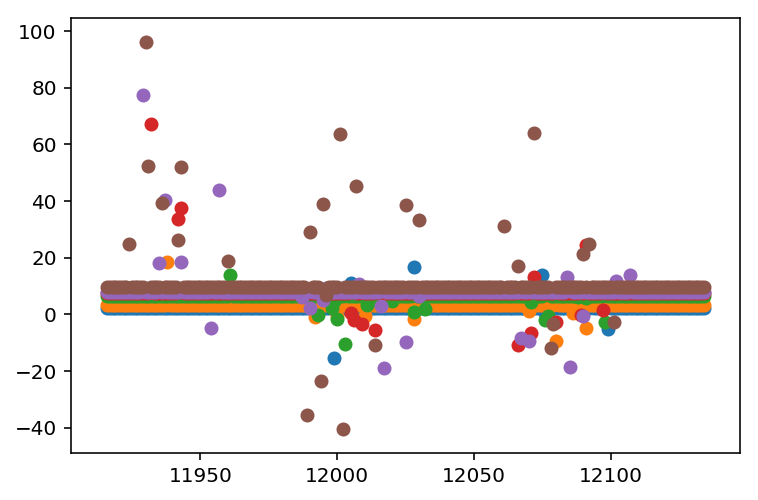

In [103]:
for i in range(6):
#    if i == 0:
    plt.scatter(int_mjd, sample_res[64][:, i], )
#    plt.xlim((59850, 60000))
plt.show()

In [104]:
sample_res = scaler.inverse_transform(y_pred.cpu().detach().numpy())
#sample_res

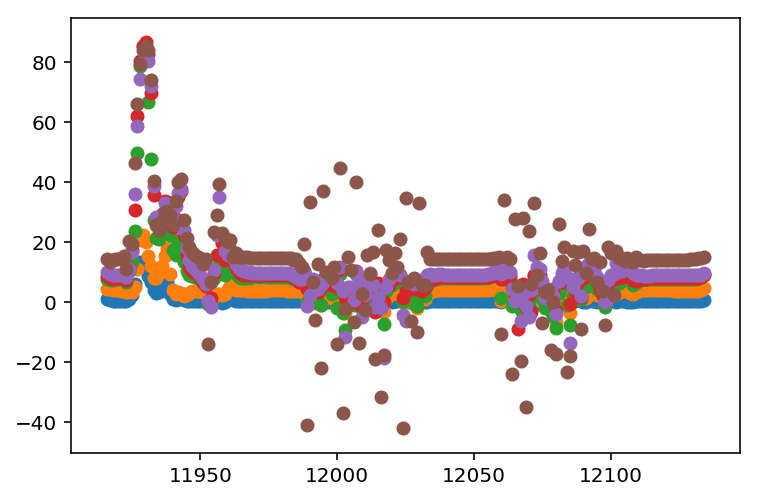

In [105]:
for i in range(6):
#    if i == 0:
    plt.scatter(int_mjd, sample_res[64][:, i], )
#    plt.xlim((59850, 60000))
plt.show()

In [78]:
int_mjd.shape, sample_res[0][:, i].shape

((951,), (951,))

In [51]:
1000 * 8 * 4300000

34400000000

### appendix

In [267]:
bilstm_ae = LSTMAE(input_size=6, hidden_size=64, num_layers=2, isCuda=False)
bilstm_ae(torch.FloatTensor(
    np.array(
        [[
            [0., 1., 3., 2., 4., 5.], 
            [0., 1., 3., 2., 4., 5.], 
            [0., 1., 3., 2., 4., 5.], 
            [0., 1., 3., 2., 4., 5.], 
        ],
         [
            [0., 1., 3., 2., 4., 5.], 
            [0., 1., 3., 2., 4., 5.], 
            [0., 1., 3., 2., 4., 5.], 
            [0., 1., 3., 2., 4., 5.], 
        ],       
        ]
    )
))

tensor([[[-0.0307, -0.0775, -0.1336, -0.0143, -0.0987, -0.0795],
         [-0.0502, -0.1022, -0.1904, -0.0041, -0.1747, -0.1190],
         [-0.0656, -0.1092, -0.2135,  0.0120, -0.2250, -0.1374],
         [-0.0776, -0.1089, -0.2206,  0.0269, -0.2561, -0.1466]],

        [[-0.0307, -0.0775, -0.1336, -0.0143, -0.0987, -0.0795],
         [-0.0502, -0.1022, -0.1904, -0.0041, -0.1747, -0.1190],
         [-0.0656, -0.1092, -0.2135,  0.0120, -0.2250, -0.1374],
         [-0.0776, -0.1089, -0.2206,  0.0269, -0.2561, -0.1466]]],
       grad_fn=<TransposeBackward0>)
(tensor([[[-0.0935,  0.2743, -0.0708, -0.0153, -0.1340,  0.3244],
         [-0.0935,  0.2743, -0.0708, -0.0153, -0.1340,  0.3244]],

        [[-0.0776, -0.1089, -0.2206,  0.0269, -0.2561, -0.1466],
         [-0.0776, -0.1089, -0.2206,  0.0269, -0.2561, -0.1466]]],
       grad_fn=<ViewBackward>), tensor([[[-0.1542,  0.5232, -0.1357, -0.0332, -0.2322,  0.7198],
         [-0.1542,  0.5232, -0.1357, -0.0332, -0.2322,  0.7198]],

        [[

tensor([[[-0.0307, -0.0775, -0.1336, -0.0143, -0.0987, -0.0795],
         [-0.0502, -0.1022, -0.1904, -0.0041, -0.1747, -0.1190],
         [-0.0656, -0.1092, -0.2135,  0.0120, -0.2250, -0.1374],
         [-0.0776, -0.1089, -0.2206,  0.0269, -0.2561, -0.1466]],

        [[-0.0307, -0.0775, -0.1336, -0.0143, -0.0987, -0.0795],
         [-0.0502, -0.1022, -0.1904, -0.0041, -0.1747, -0.1190],
         [-0.0656, -0.1092, -0.2135,  0.0120, -0.2250, -0.1374],
         [-0.0776, -0.1089, -0.2206,  0.0269, -0.2561, -0.1466]]],
       grad_fn=<TransposeBackward0>)

In [5]:
class MKRankGaussScalar(object):
    """usage: 
    rgs = RankGaussScalar()
    rgs.fit(df_X)
    df_X_converted = rgs.transform(df_X)
    df_X_test_converted = rgs.transform(df_X_test)
    """
    def __init__(self):
        self.fit_done = False

    def rank_gauss(self, x):
        N = x.shape[0]
        temp = x.argsort()
        rank_x = temp.argsort() / N
        rank_x -= rank_x.mean()
        rank_x *= 2
        efi_x = erfinv(rank_x)
        efi_x -= efi_x.mean()
        return efi_x

    def fit(self, df_x):
        """
        df_x: fitting対象のDataFrame
        """
        self.train_unique_rankgauss = {}
        self.target_cols = np.sort(df_x.columns)
        for c in self.target_cols:
            unique_val = np.sort(df_x[c].unique())
            self.train_unique_rankgauss[c]= [unique_val, self.rank_gauss(unique_val)]
        self.fit_done = True

    def transform(self, df_target):
        """
        df_target: transform対象のDataFrame
        """
        assert self.fit_done
        assert np.all(np.sort(np.intersect1d(df_target.columns, self.target_cols)) == np.sort(self.target_cols))
        df_converted_rank_gauss = pd.DataFrame(index=df_target.index)
        for c in self.target_cols:
            df_converted_rank_gauss[c] = np.interp(df_target[c], 
                                                   self.train_unique_rankgauss[c][0], 
                                                   self.train_unique_rankgauss[c][1]) # ,left=0, right=0)
        return df_converted_rank_gauss

In [39]:
epochs = 10000
exp = 1

tt = torch.cuda if DEVICE=='cuda' else torch
losses = []

for i in range(1):
    # ae 定義
    bilstm_ae = LSTMAE(input_size=6, hidden_size=32, num_layers=3, isCuda=DEVICE, dropout=0.2)
    if DEVICE == 'cuda':
        bilstm_ae=bilstm_ae.cuda()
    # dataset 加工
    dataset = plasticcDatasetForAE(x_trn, y_trn, err_trn)
    #dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
    optimizer = optim.SGD(bilstm_ae.parameters(), lr=1., momentum=0.0)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    optimizer = optim.RMSprop(bilstm_ae.parameters(), )
    #optimizer = optim.RMSprop(bilstm_ae.parameters(), lr=1., momentum=0.0)
    #scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
    #optimizer = optim.Adam(bilstm_ae.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        epoch_losses = []
#        scheduler.step()
        bilstm_ae = bilstm_ae.train()
        for i_batch, sample_batched in enumerate(dataloader):
            optimizer.zero_grad()
            x_trn_batch, y_trn_batch, err_trn_batch = sample_batched
            x_trn_batch, y_trn_batch, err_trn_batch = Variable(tt.FloatTensor(x_trn_batch).cuda()), Variable(tt.FloatTensor(y_trn_batch).cuda()), Variable(tt.FloatTensor(err_trn_batch).cuda())
            #x_trn_batch, y_trn_batch, err_trn_batch = Variable(x_trn_batch), Variable(y_trn_batch), Variable(err_trn_batch)
            y_pred = bilstm_ae(x_trn_batch)
            loss = WMSE(y_trn_batch, y_pred, err_trn_batch)
            loss.backward()
            optimizer.step()
            if DEVICE=='cuda':
                batch_loss = loss.cpu().detach().numpy()
            else:
                batch_loss = loss.detach().numpy()
            epoch_losses.append(batch_loss)

        bilstm_ae = bilstm_ae.eval()
        val_losses = []
        #for i in range(val_err_trn.shape[0]//1024):
        #    val_y_pred = bilstm_ae(tt.FloatTensor(x_val[1024*i:1024*(i+1)]).cuda())
        #    val_loss = WMSE(tt.FloatTensor(y_val[1024*i:1024*(i+1)]).cuda(), val_y_pred, tt.FloatTensor(val_err_trn[1024*i:1024*(i+1)]).cuda()).cpu().detach().numpy()
        #    val_losses.append(val_loss)
        epoch_loss = np.mean(epoch_losses)
        #val_loss = np.mean(val_loss)
        #print(epoch_loss, val_loss)
        print(epoch_loss)
        losses.append(epoch_loss)
        #torch.save(bilstm_ae, f'../models/exp{exp}_{i_batch}_{epoch_loss}_{val_loss}.mdl')
        torch.save(bilstm_ae, f'../models/exp{exp}_{i_batch}_{epoch_loss}.mdl')

/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0.9061043


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36868307


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36390427


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36325166


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.3627417


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.3626152


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36209154


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36313334


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.3677137


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.35963997


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36334848


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.35651258


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.35615802


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.36132059


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.32430184


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.26697132


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.22625041


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.28151545


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.21214123


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.20195194


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.21251297


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.18435824


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.87714696


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.37622055


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.3316143


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.30007273


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.28473732


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.26050386


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.24552922


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.23587386


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.22509761


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.21968472


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.21766973


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.20972623


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.20038052


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.19652934


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.18848895


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.18317431


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.18989146


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1803409


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.17681265


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.16644116


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.16520427


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.16318841


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.16664308


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1550617


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.15428822


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1590784


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1524853


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14607364


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14525528


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.15298696


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14139938


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13961934


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.15201731


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13705045


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1370522


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13822496


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13901861


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1399542


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13972649


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13302386


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13278109


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13465284


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14057226


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13073786


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13063274


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.15754952


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1365728


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13196526


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13265671


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12948218


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12688293


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13088357


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1295072


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14547275


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12611814


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12789623


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1390098


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12552248


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12459729


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12602168


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12993506


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14530842


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.14100105


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12604807


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12485694


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13100496


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12295592


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12187078


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12788779


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.123154484


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.122728385


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13836056


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12079653


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12779152


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12027613


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12706868


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11993584


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12272931


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12528662


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13112031


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12002704


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.16710049


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.16243783


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13105167


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12578018


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12426448


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12635198


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11976109


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12169102


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11498478


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.116582245


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11409605


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.12241907


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13121058


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11298847


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.10954317


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.10954722


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11462501


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11116118


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.10480023


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.105329394


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.104055755


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11592137


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11046191


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.101451434


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.11475047


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.101914205


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09910178


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.109913535


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09871303


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0978907


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09961351


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.102389865


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09999446


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.107640915


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09709672


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09640948


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09464067


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09781171


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09070229


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.099212885


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09102916


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08979693


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09348648


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09763971


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0997937


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09920061


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09928277


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09209076


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09531059


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08851451


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0924496


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.090094626


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0878601


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08476371


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08625386


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.087290026


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09767427


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.1260093


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09799852


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09297776


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09289775


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08993905


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08783569


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09603053


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09608198


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08677652


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.088365756


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08308307


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08425998


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08352386


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08157198


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.083417505


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09176219


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.084880196


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08207637


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.10103326


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0904986


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08989844


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08686555


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08130645


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08063889


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08109364


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08887023


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.089773774


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.083042145


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08269751


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08064273


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08259237


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08344426


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08011994


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08227417


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08776768


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07992844


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09910513


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08497094


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.094421975


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.090810575


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.09376866


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08432747


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08008214


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08205647


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08043363


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08277812


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.080351286


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08322203


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08027566


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07946094


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08332191


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07866294


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07834664


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0771924


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07630922


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07894394


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0796181


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08177681


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07813716


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.083351314


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07856178


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.077137046


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07555403


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.075114615


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.076572925


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.087158054


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.082896434


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07412312


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07757644


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.075469345


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.102385886


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.13747416


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.103131585


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08413064


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.08606884


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.07928259


/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LSTMAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderbiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/naoya.taguchi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

In [14]:
! ls ~

ae_train_flux_v2.pkl.gz
ae_train_hidden_v2.pkl.gz
anaconda3
LightGBM_compilation.log
nvim
PLASTICC_NET_weight-multi-logloss-0.490504_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.491045_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.49243_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.493528_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.494562_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.500707_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.500707_taguchi_nn_last_taguchi_nn_last.pkl
PLASTICC_NET_weight-multi-logloss-0.501635_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.501635_taguchi_nn_last_taguchi_nn_last.pkl
PLASTICC_NET_weight-multi-logloss-0.501833_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.501833_taguchi_nn_last_taguchi_nn_last.pkl
PLASTICC_NET_weight-multi-logloss-0.503846_taguchi_nn_last.csv
PLASTICC_NET_weight-multi-logloss-0.503846_taguchi_nn_last_taguchi_nn_last.pkl
PLASTICC_NET_weight-multi-lo

In [16]:
ae_df = pd.read_pickle('/home/naoya.taguchi/ae_train_flux_v2.pkl.gz', compression='gzip')

In [17]:
set_df

,object_id,passband,flux,flux_err,detected,phase,int_mjd
0,615,2,-544.810303,3.622952,1,0.816429,11950
1,615,1,-816.434326,5.553370,1,0.840157,11950
2,615,3,-471.385529,3.801213,1,0.863886,11950
3,615,4,-388.984985,11.395031,1,0.884533,11950
4,615,2,-681.858887,4.041204,1,0.930728,11950
5,615,1,-1061.457031,6.472994,1,0.954457,11950
6,615,3,-524.954590,3.552751,1,0.978185,11950
7,615,4,-393.480225,3.599346,1,0.012084,11950
8,615,5,-355.886780,10.421921,1,0.043208,11950
9,615,2,-548.013550,3.462291,1,0.815862,11953
